In [1]:
import tensorflow as tf

# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [2]:
model = tf.keras.models.load_model('../../../../build/saved_model/Simple_CNN/HDF5/Simple_CN.h5', compile=True)

## 1    Preparing and pre-processing data

In [3]:
# Load data and normalize
from art.utils import load_cifar10
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [4]:
# Select 10 and 100 random simple from Test set to test the algorithm
random_sample_10 = np.random.randint(low = 0, high = 10000, size = 10)
random_sample_10 = np.sort(random_sample_10).tolist()

random_sample_100 = np.random.randint(low = 0, high = 10000, size = 100)
random_sample_100 = np.sort(random_sample_100).tolist()

#x_test_10 = x_test[random_sample_10,:,:,:]
#x_test_100 = x_test[random_sample_100,:,:,:]

x_test_10 = x_test[random_sample_10,:]
x_test_100 = x_test[random_sample_100,]

y_test_10 = y_test[random_sample_10, :]
y_test_100 = y_test[random_sample_100, :]

x_test_10_ori = x_test_10.copy()
x_test_100_ori = x_test_100.copy()


## 2.    Implementing the I-FGSM Method with Keras and TensorFlow

In [5]:
# Function to calculate adversary noise
def generate_adversary(image, label):
  '''Generates adversarial noise for a given image and label
  Args:
    image(np.array):  input image, shape like (1, height, width, channels)
    label(int): label of the image, shape like (nb_classes, )
  
  Returns:
    sign_grad(tf.Tensor): adversarial noise, should be changed to numpy array before add to the image.T
                          shape like (1, height, width, channels)
  '''

  # Change the image to a tensor
  image = tf.cast(image, tf.float32)

  #record gradients
  with tf.GradientTape() as tape:

    tape.watch(image)

    prediction = model(tf.reshape(image, (1, 32, 32, 3)))
    loss = tf.keras.losses.MSE(label, prediction)
    
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

In [6]:
generate_adversary(x_test_10[0], y_test_10[0]).shape

TensorShape([32, 32, 3])

In [7]:
def I_FSGM(image, label, alpha, epsilon):
    '''Performs I-FSGM attack on a given image and label
    Formula:
        X_0_adv = X
        X_N+1_adv = Clip(X_N_adv + alpha * sign(grad(X_N_adv, Y_true)))
        alpha selected from 1
        iterations to be min(epsilon+4, 1.25 * epsilon)

    Args:
        image(np.array):  input image, shape like (height, width, channels)
        label(int): label of the image, shape like (nb_classes, )
        alpha(float): alpha parameter for I-FSGM
        epsilon(int): epsilon parameter for I-FSGM
    
    Examples:
        >>> tmp = I_FSGM(train_images[0], train_labels[0], 0.1, 5)
    
    Returns:
        adv_image(np.array): adversarial image, shape like (height, width, channels)
    '''

    image = image.reshape(1,32,32,3)
    
    for i in range(int(min(epsilon+4, 1.25 * epsilon))):

        # Generate adversarial noise
        # Because the original image is already between [0, 1], the resulting pixels are also divided by 255
        sign_grad = (generate_adversary(image, label)).numpy()

        img_adv = (image + alpha * sign_grad).reshape(32,32,3)

        
        for j in range(len(img_adv)):
            for k in range(len(img_adv[j])):
                for l in range(len(img_adv[j][k])):

                    img_adv[j][k] = np.clip(img_adv[j][k] , image[0][j][k]  - epsilon/255, image[0][j][k]  + epsilon/255)
                
                    if img_adv[j][k][l] > 1:
                        img_adv[j][k][l] = 1
                    elif img_adv[j][k][l] < 0:
                        img_adv[j][k][l] = 0

        image = img_adv.reshape(1,32,32,3)

    return image.reshape(32,32,3)

## 3. Test Function and select different parameters

### 3.1 Use a sample to test the accuracy after attack and plot it

In [8]:
index_tmp = random.randint(0, len(x_train)-1)

# used to generate adversarial image
image_test1 = x_train[index_tmp]
image_test1_label = y_train[index_tmp]

# original input image
image_test2 = image_test1.copy()

In [9]:
image_test1_adv = I_FSGM(image_test1, image_test1_label, 1, 5)

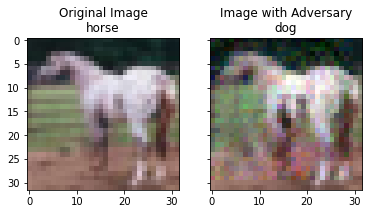

In [10]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image_test2)
ax1.set_title(f"Original Image\n{label_names[model(image_test2.reshape(1,32,32,3)).numpy().argmax()]}")
ax2.imshow(image_test1_adv)
ax2.set_title(f"Image with Adversary\n{label_names[model(image_test1_adv.reshape(1,32,32,3)).numpy().argmax()]}")
plt.show()

### Classifier

In [11]:
from art.estimators.classification import TensorFlowV2Classifier

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [13]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


classifier = TensorFlowV2Classifier(model=model, loss_object=loss_object, train_step=train_step, nb_classes=10, input_shape=(32, 32, 3), clip_values=(min_, max_))

#classifier.fit(x_train, y_train, batch_size=128, nb_epochs=3)

In [16]:
x_test_adv = []

for i in range(100):
    x_test_adv.append(I_FSGM(x_test[i], y_test[i], 1, 5))

In [17]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_10, axis=1)) / len(y_test_10)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 0.0%


C:\Users\CYQ\AppData\Local\Temp\ipykernel_12128\2723709181.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_10, axis=1)) / len(y_test_10)
